In [ ]:
############ LOAD in custom packages ################
import sys
import os
import pandas as pd
import numpy as np
import importlib
from fastdtw import dtw

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Add project root to sys.path
sys.path.append(project_root)

# Import and reload custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import feature_selection as fs
from scripts import clustering as cl
importlib.reload(pre)
importlib.reload(vis)
importlib.reload(fs)
importlib.reload(cl)


################ DEFINE column variables ###################

## Baseline cols
mhs_cols = ['mhs_1','mhs_2','mhs_3','mhs_4','mhs_5']
gad_cols = ['gad7_1','gad7_2','gad7_3','gad7_4','gad7_5','gad7_6','gad7_7','gad7_8','gad7_sum','gad_cat']
phq9_base = ['phq9_1_base','phq9_2_base','phq9_3_base','phq9_4_base','phq9_5_base','phq9_6_base','phq9_7_base','phq9_8_base','phq9_9_base','phq9_sum_base']
mania = ['screen_1','screen_2','screen_3','screen_4']
demographics = ['gender','education','working','income_satisfaction','income_lastyear','marital_status','race','age','heard_about_us','device']
alc_cols = ['alc_1','alc_2','alc_3','alc_sum']

## Weekly cols
phq9_cols = ['phq9_1','phq9_2','phq9_3','phq9_4','phq9_5','phq9_6','phq9_7','phq9_8','phq9_9','phq9_sum']
sds_cols = ['sds_1','sds_2','sds_3','stress','support']
sleep_cols = ['sleep_1','sleep_2','sleep_3']
gic_cols = ['mood_1']

weekly_cols = phq9_cols + sds_cols + sleep_cols + gic_cols

#### Daily Cols

phq2_cols = ['phq2_1','phq2_2','phq2_sum']

daily_cols_v1 = ['aggregate_communication', 'call_count',
       'call_duration', 'interaction_diversity', 'missed_interactions',
       'mobility', 'mobility_radius', 'sms_count', 'sms_length',
       'unreturned_calls']


daily_v2_sensor = ['distance_walking', 'hours_active', 'distance_active',
        'came_to_work','distance_powered_vehicle',
       'hours_high_speed_transportation', 'hours_of_sleep',
       'distance_high_speed_transportation',
       'hours_powered_vehicle', 'hours_stationary', 'hours_stationary_nhw',
       'hours_walking', 'location_variance']

daily_v2_phone = ['callDuration_incoming','callCount_missed',
        'callCount_outgoing','callCount_incoming',
       'callDuration_outgoing', 'textCount', 'textCount_received',
       'textCount_sent', 'textLength_received', 'textLength_sent',
       'uniqueNumbers_calls_incoming', 'uniqueNumbers_calls_missed',
       'uniqueNumbers_calls_outgoing', 'uniqueNumbers_texts',
       'uniqueNumbers_texts_received', 'uniqueNumbers_texts_sent']

daily_v2_weather = ['cloud_cover_mean','dew_point_mean',
        'humidity_mean','temp_mean','dew_point_IQR','humidity_IQR',
        'temp_IQR','cloud_cover_IQR','cloud_cover_std','dew_point_std',
        'humidity_std','temp_std','cloud_cover_median','dew_point_median',
        'humidity_median','temp_median','precip_sum']

daily_v2_common = ['distance_walking', 'hours_active', 'distance_active',
        'distance_powered_vehicle','hours_of_sleep','hours_powered_vehicle',
          'hours_stationary', 'hours_stationary_nhw','hours_walking']

daily_misc_cols = 'hours_accounted_for'
mobility_cols = ['mobility','mobility_radius']


# Aggregated variable lists
numeric_cols = daily_cols_v1 + daily_v2_sensor + daily_v2_phone + phq2_cols + phq9_cols + weekly_cols
passive_cols = daily_cols_v1 + daily_v2_sensor + daily_v2_phone
survey_cols = phq2_cols + weekly_cols




############# Load in dfs scaled ###############
df_names = ['v1_day', 'v2_day', 'v1_week_phq9', 'v2_week_phq9']
dfs_scaled = {}
for name in df_names:
    dfs_scaled[name] = pd.read_csv(os.path.join(brighten_dir, f'{name}_scaled.csv'))




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


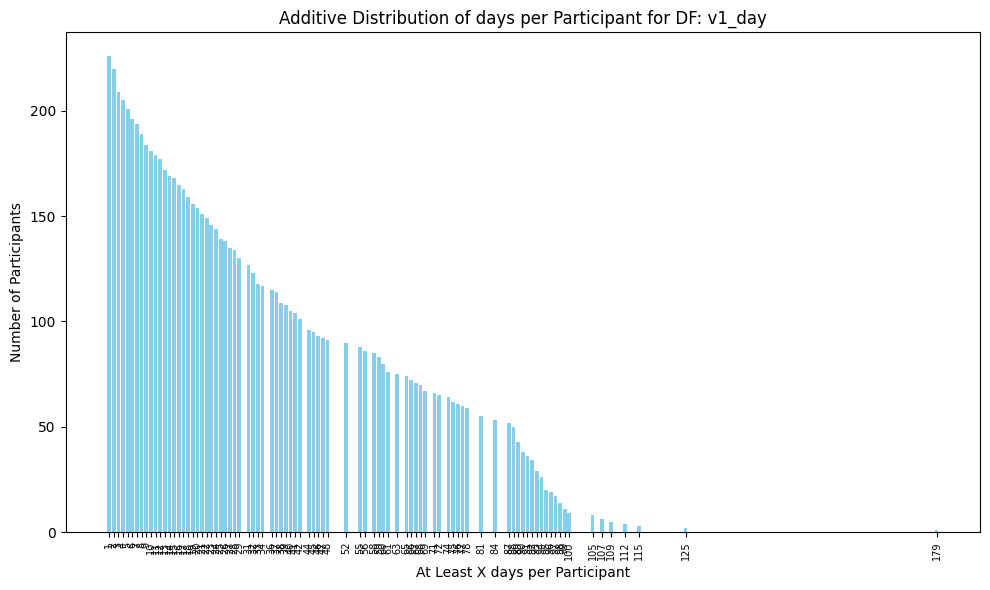

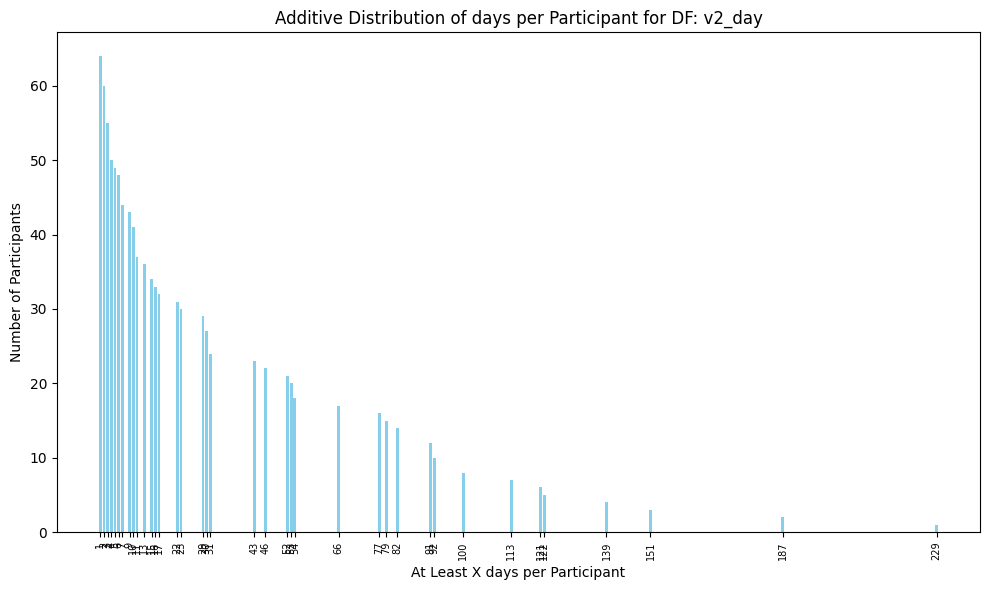

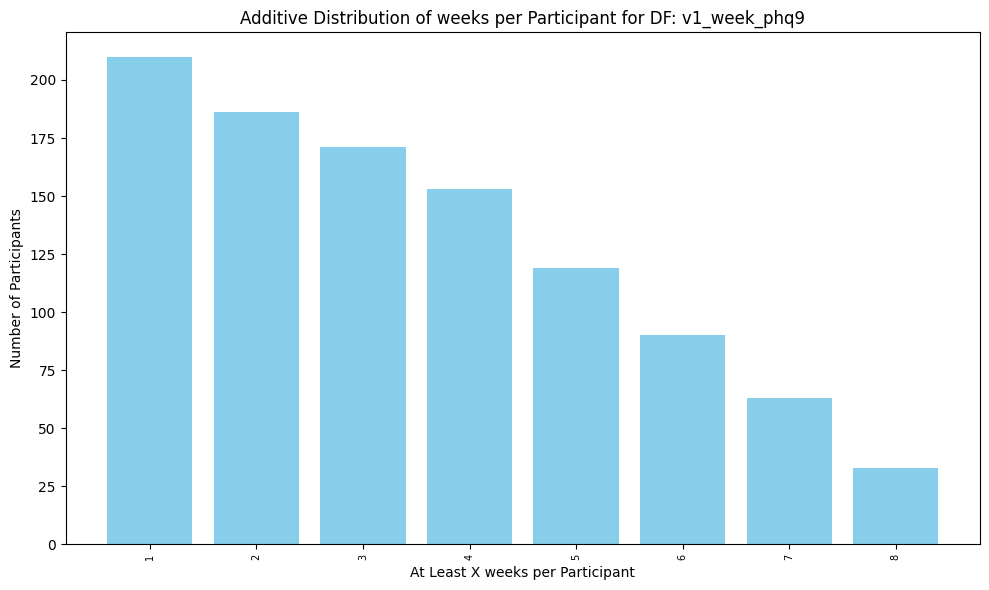

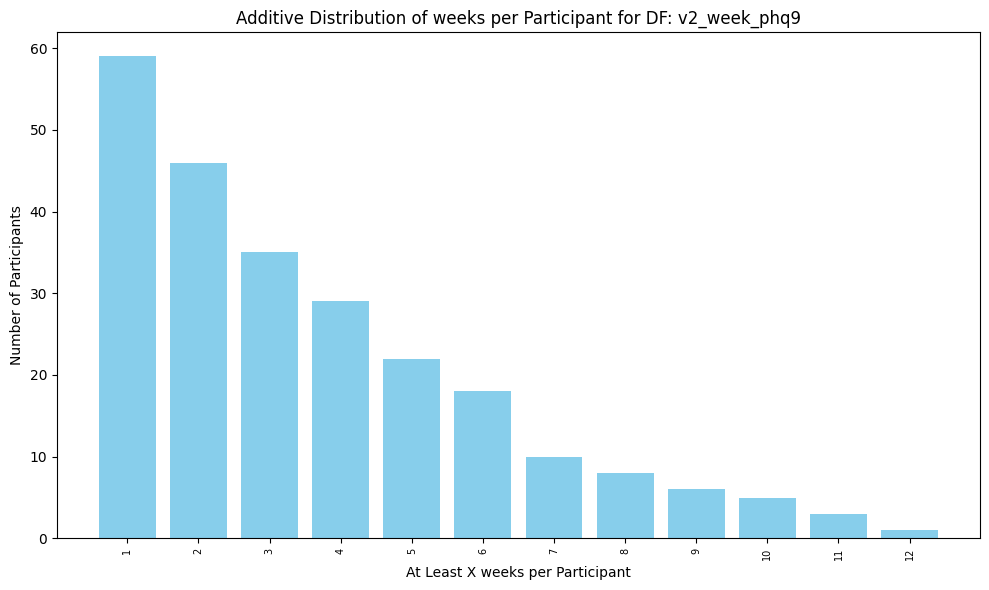

In [16]:
############## Plot-- how many weeks/days does each participant have #############
for name, df in dfs_scaled.items():
    if 'day' in name:
        vis.plot_participants_per_time(df, time_period='day', title=name)
    elif 'week' in name:
        vis.plot_participants_per_time(df, time_period='week', title=name)





DATAFRAME: v1_day
In df there are 226 subjects.


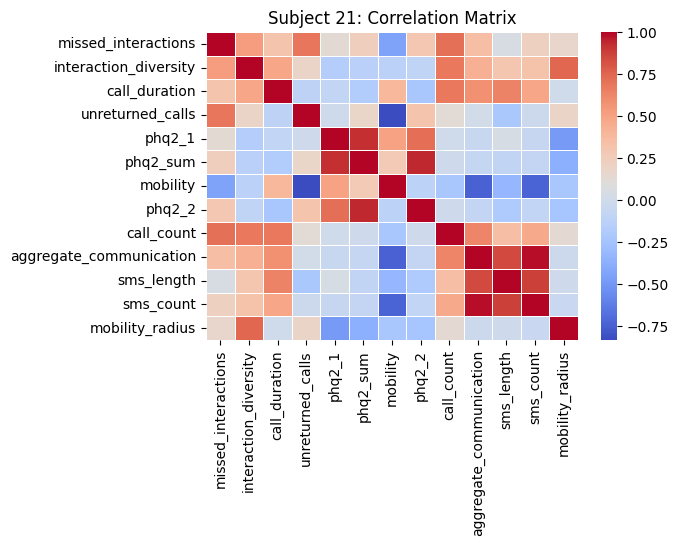

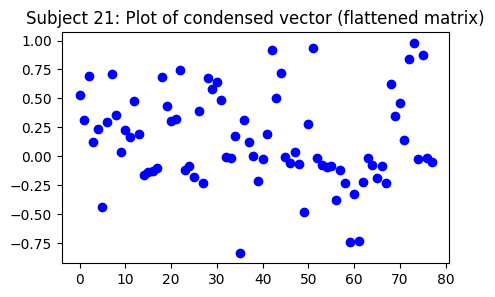

220 subs with symptom matrices
220 filled condensed arrays


DATAFRAME: v2_day
In df there are 64 subjects.


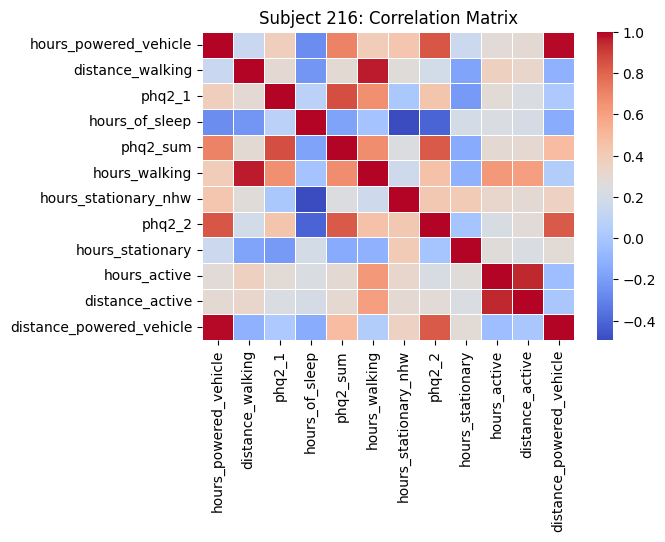

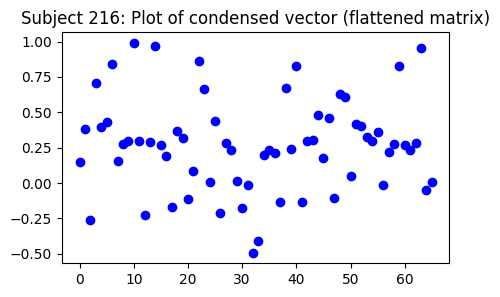

60 subs with symptom matrices
60 filled condensed arrays


DATAFRAME: v1_week_phq9
In df there are 210 subjects.


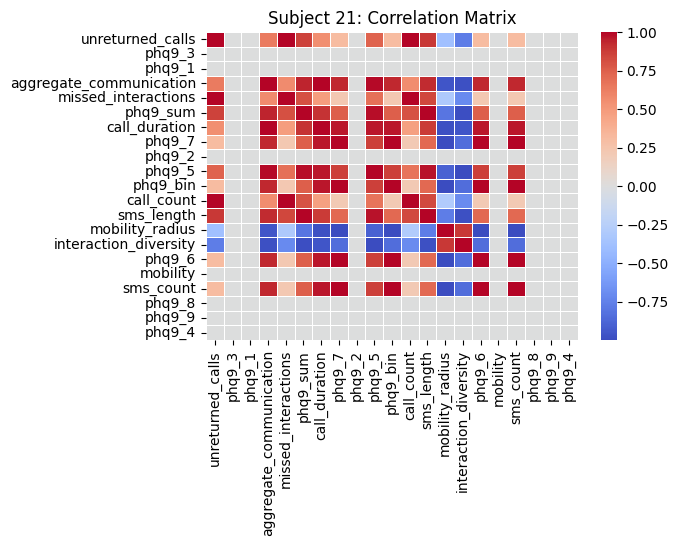

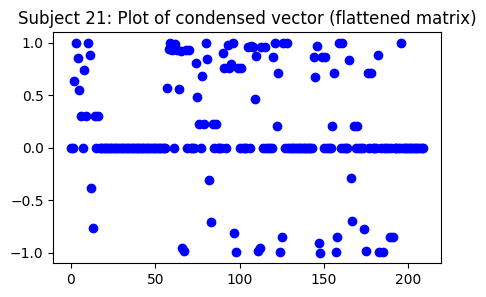

186 subs with symptom matrices
186 filled condensed arrays


DATAFRAME: v2_week_phq9
In df there are 59 subjects.


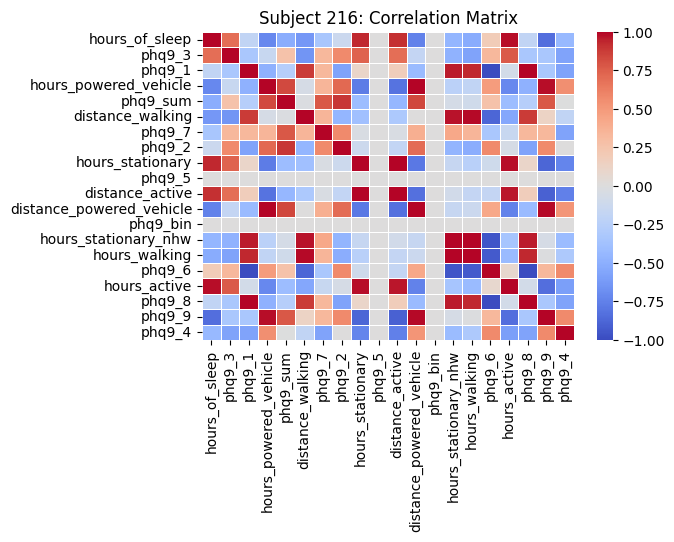

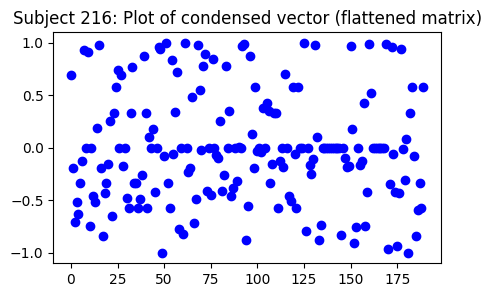

46 subs with symptom matrices
46 filled condensed arrays


In [ ]:
#### Take the average of each subject's symptom correlation and use it to make clusters of variables
symptom_matrices_df_dict = {}
flattened_matrices_df_dict = {}
demographic_vars = ['gender','education','race','age']                # covariates
id_vars = ['participant_id','num_id','dt','week','day']                              # vv define to_modify as all the other columns to do regression on


# Create dicts of all subjects' correlation matrices
for name, df in dfs_scaled.items():
    print(f'\n\nDATAFRAME: {name}')
    ignore_cols = demographic_vars + id_vars
    symptom_matrix_dict, flattened_matrix_dict = fs.make_symptom_matrices(df, ignore_cols, num_to_plot=1)
    symptom_matrices_df_dict[name] = symptom_matrix_dict
    flattened_matrices_df_dict[name] = flattened_matrix_dict



/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/clustering.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


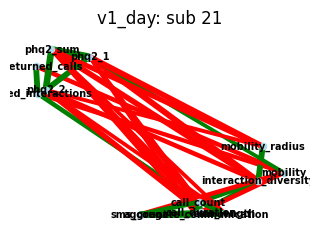

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/clustering.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


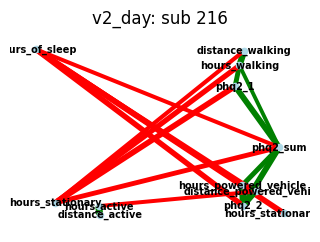

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/clustering.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


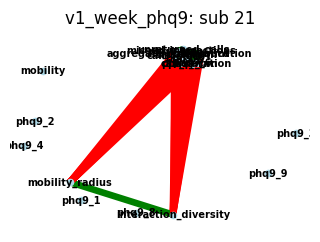

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/clustering.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


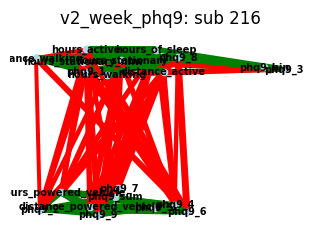

In [ ]:
############### Plot individual networks of symptom matrices #################

for name, df_dict in symptom_matrices_df_dict.items():
    count=0
    for sub, corr_matrix in df_dict.items():
        if count<1:
            fs.plot_network(corr_matrix, title=f'{name}: sub {sub}')
            count=+1

In [112]:
# Double check where 'labels' are for columns
symptom_matrices_df_dict['v1_day'][list(symptom_matrices_df_dict['v1_day'].keys())[0]].index

Index(['missed_interactions', 'interaction_diversity', 'call_duration',
       'unreturned_calls', 'phq2_1', 'phq2_sum', 'mobility', 'phq2_2',
       'call_count', 'aggregate_communication', 'sms_length', 'sms_count',
       'mobility_radius'],
      dtype='object')

v1_day
(13, 13) variables included


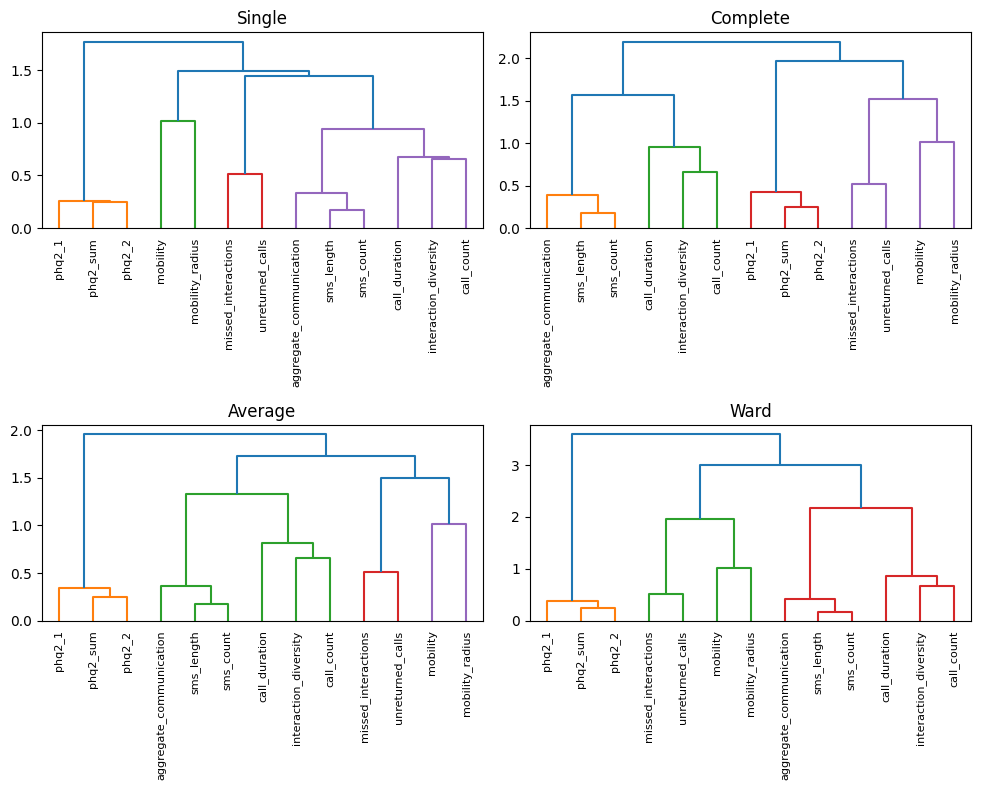

v2_day
(12, 12) variables included


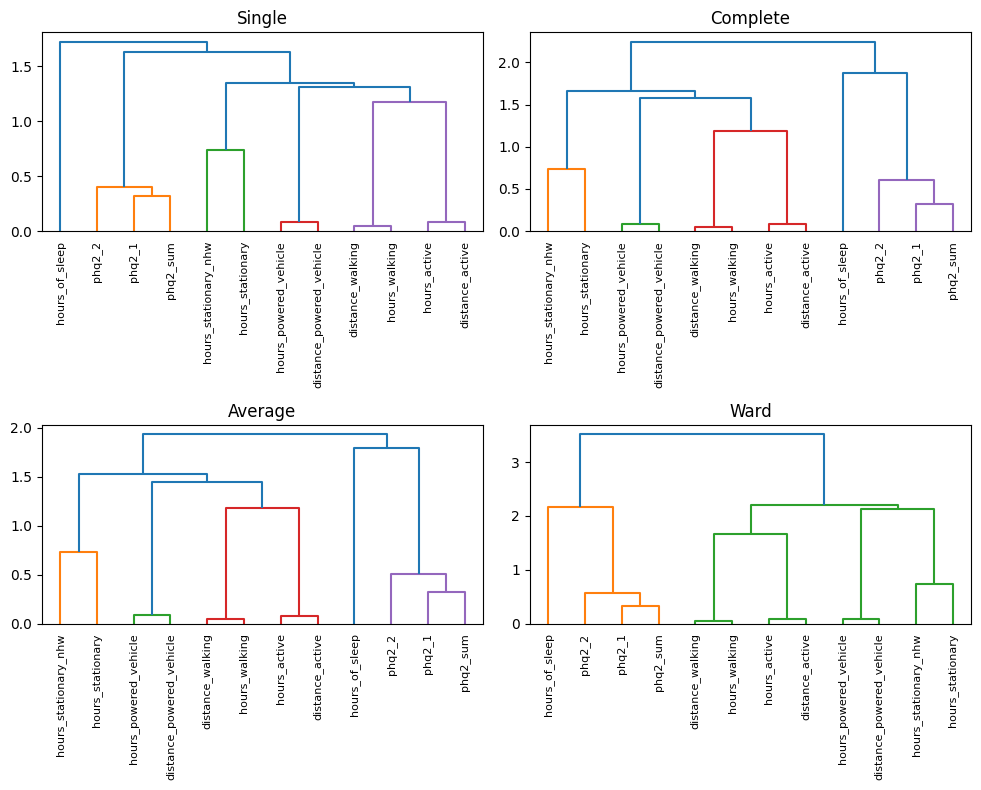

v1_week_phq9
(21, 21) variables included


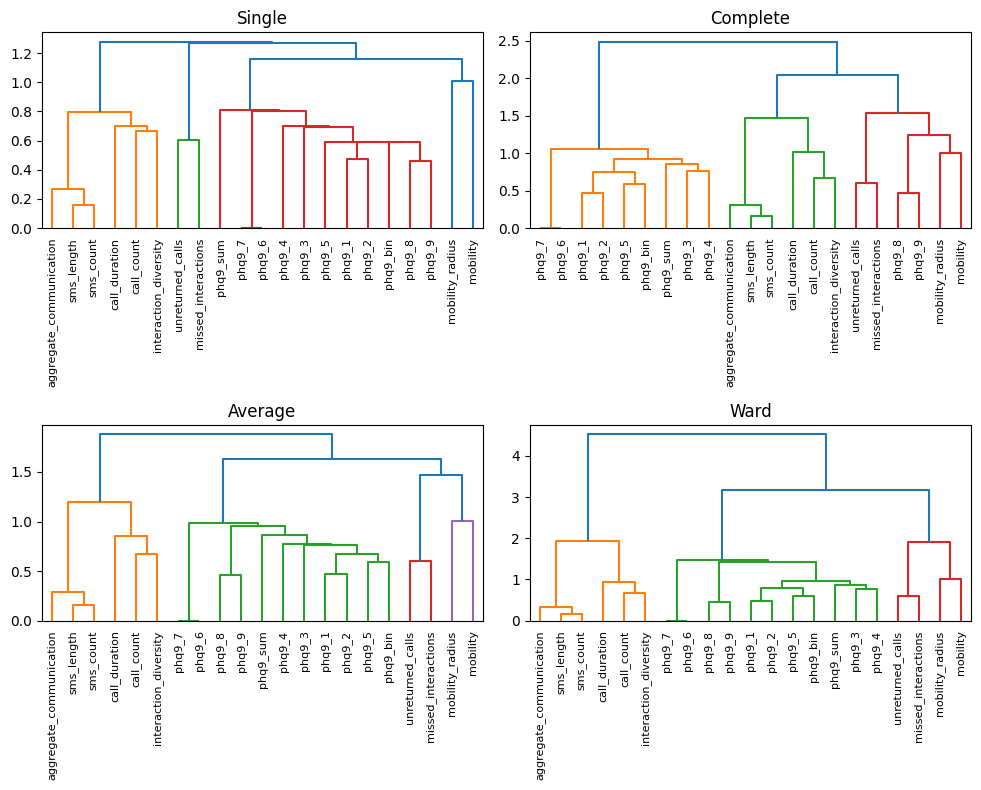

v2_week_phq9
(20, 20) variables included


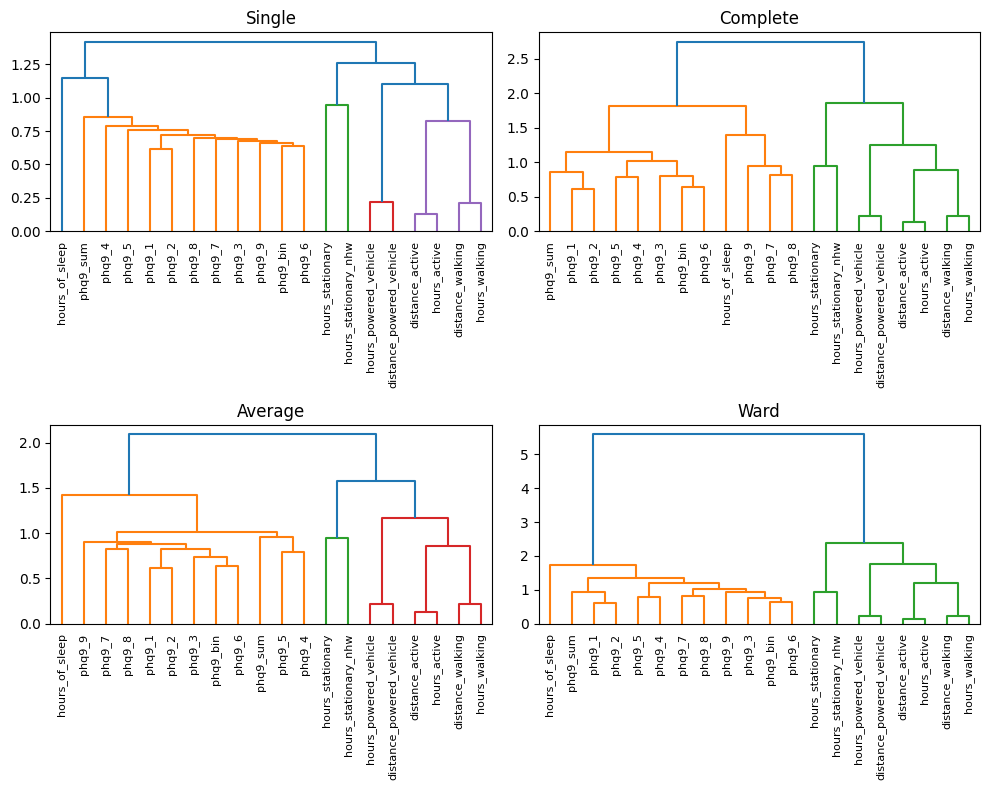

In [ ]:
## Plot options
for name, df in symptom_matrices_df_dict.items():
    avg_matrix = fs.average_matrix(df)
    fs.plot_hier_agg(avg_matrix, df[list(df.keys())[0]].index, is_dict=False, group_title=f'{name}') # 3, ward


Mark down best fits:
v1_day -> 5, average
v1_week_phq9 -> 5, single
v2_day_fm -> 5, single
v2_week_phq9_fm -> 5 single


In [ ]:
################# Create cluster_dict of Variables + Cluster Labels ############

clust_dict = {}
# clust_dict['v1_day'] = v1_day_clust_dict
for name, dictionary in symptom_matrices_df_dict.items():
    if 'v1' in name:
        avg_matrix = fs.average_matrix(dictionary)
        clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=5, linkage='average', is_dict=False)
for name, dictionary in symptom_matrices_df_dict.items():
    if 'v2' in name:
        avg_matrix = fs.average_matrix(dictionary)
        clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=5, linkage='single', is_dict=False)

In [ ]:
################# Create df_pca of Variables + 1st PC of clusters Labels ############

dfs_pca = {}
dfs_pca_dict = {}
for name, df in dfs_scaled.items():
    name = name.replace('_residuals_scaled','')
    print(f'\nFor {name}')
    dfs_pca[name], dfs_pca_dict[name] = fs.pca_on_clusters(dfs_scaled[name], clust_dict[name], n_clusters=5)



For v1_day
Cols for cluster 0: ['mobility', 'mobility_radius']
Cols for cluster 1: ['missed_interactions', 'unreturned_calls']
Cols for cluster 2: ['call_count', 'call_duration', 'interaction_diversity']
Cols for cluster 3: ['phq2_1', 'phq2_2', 'phq2_sum']
Cols for cluster 4: ['aggregate_communication', 'sms_count', 'sms_length']

For v2_day
Cols for cluster 0: ['distance_walking', 'hours_active', 'distance_active', 'hours_walking']
Cols for cluster 1: ['hours_stationary', 'hours_stationary_nhw']
Cols for cluster 2: ['phq2_1', 'phq2_2', 'phq2_sum']
Cols for cluster 3: ['hours_of_sleep']
Cols for cluster 4: ['distance_powered_vehicle', 'hours_powered_vehicle']

For v1_week_phq9
Cols for cluster 0: ['mobility', 'mobility_radius']
Cols for cluster 1: ['call_count', 'call_duration', 'interaction_diversity']
Cols for cluster 2: ['phq9_1', 'phq9_2', 'phq9_3', 'phq9_4', 'phq9_5', 'phq9_6', 'phq9_7', 'phq9_8', 'phq9_9', 'phq9_sum', 'phq9_bin']
Cols for cluster 3: ['missed_interactions', 'unre

In [ ]:
# # Name the clusters
dfs_pca_dict['v1_day'][0]['name']= 'pc_mobility'
dfs_pca_dict['v1_day'][1]['name']= 'pc_missed_communications'
dfs_pca_dict['v1_day'][2]['name']= 'pc_calls'
dfs_pca_dict['v1_day'][3]['name']= 'pc_depression'
dfs_pca_dict['v1_day'][4]['name']= 'pc_sms'

dfs_pca_dict['v2_day'][0]['name']= 'pc_activity'
dfs_pca_dict['v2_day'][1]['name']= 'pc_stationary_hours'
dfs_pca_dict['v2_day'][2]['name']= 'pc_depression'
dfs_pca_dict['v2_day'][3]['name']= 'pc_sleep_hours'
dfs_pca_dict['v2_day'][4]['name']= 'pc_vehicle'

dfs_pca_dict['v1_week_phq9'][0]['name']= 'pc_mobility'
dfs_pca_dict['v1_week_phq9'][1]['name']= 'pc_calls'
dfs_pca_dict['v1_week_phq9'][2]['name']= 'pc_depression'
dfs_pca_dict['v1_week_phq9'][3]['name']= 'pc_missed_communications'
dfs_pca_dict['v1_week_phq9'][4]['name']= 'pc_sms'

dfs_pca_dict['v2_week_phq9'][0]['name']= 'pc_stationary_hours'
dfs_pca_dict['v2_week_phq9'][1]['name']= 'pc_depression'
dfs_pca_dict['v2_week_phq9'][2]['name']= 'pc_vehicle'
dfs_pca_dict['v2_week_phq9'][3]['name']= 'pc_sleep_hours'
dfs_pca_dict['v2_week_phq9'][4]['name']= 'pc_activity'



for name, df in dfs_pca.items():
    dfs_pca[name] = fs.merge_df_via_cluster_pca_dict(dfs_scaled[name], dfs_pca_dict[name], on_columns=['num_id', 'dt', 'week'])
    dfs_pca[name].to_csv(os.path.join(brighten_dir, f'{name}_pca.csv'), index=False)




/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/clustering.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


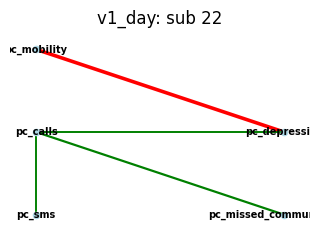

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/clustering.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


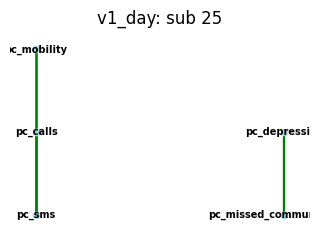

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/clustering.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


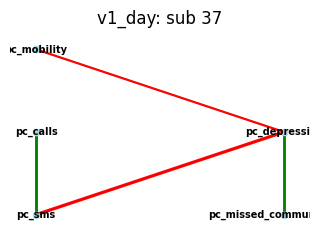

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/clustering.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


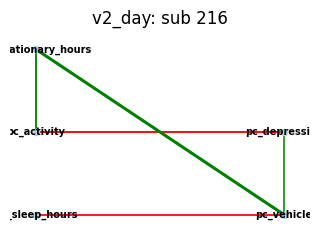

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/clustering.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


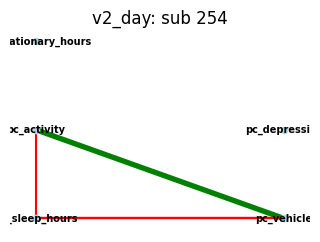

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/clustering.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


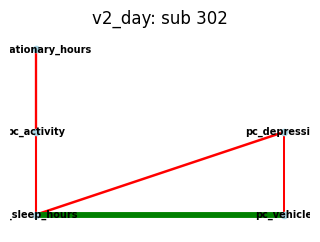

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/clustering.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


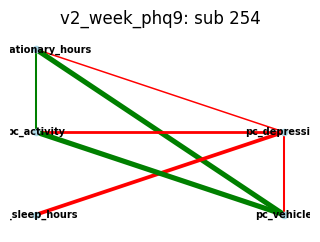

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/clustering.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


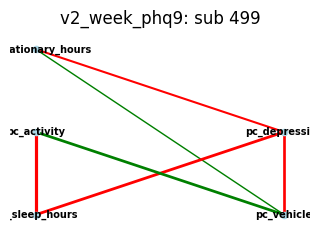

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/clustering.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


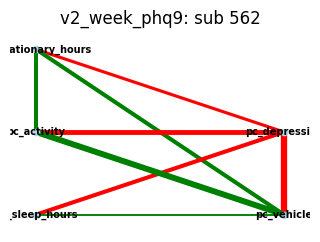

In [ ]:
############ Plot subjects' individual networks of PCs ############

# Predefine fixed positions for nodes
fixed_positions_v1 = {
    'pc_calls': (1, 2),
    'pc_sms': (1, 1),
    'pc_missed_communications': (2, 1),
    'pc_mobility': (1, 3),
    'pc_depression': (2, 2)
}

fixed_positions_v2 = {
    'pc_activity': (1, 2),
    'pc_sleep_hours': (1, 1),
    'pc_vehicle': (2, 1),
    'pc_stationary_hours': (1, 3),
    'pc_depression': (2, 2)
}


for name, df in dfs_pca.items():
    count=0
    cols=[col for col in df.columns.to_list() if 'pc_' in col]
    for sub in df['num_id'].unique():
        sub_df = df[df['num_id']==sub]
        if sub_df.shape[0] > 8:
            if count<3:
                if 'v1' in name:
                    fs.plot_network(sub_df, cols, title=f'{name}: sub {sub}', threshold=0.2, fixed_positions=fixed_positions_v1)
                    count+=1
                elif 'v2' in name:
                    fs.plot_network(sub_df, cols, title=f'{name}: sub {sub}', threshold=0.2, fixed_positions=fixed_positions_v2)
                    count+=1
